In this notebook we will try methods inspired in the [deep docking method](https://onlinelibrary.wiley.com/doi/full/10.1002/minf.202000028) applied to the cytochromes dataset. For training and testing we will use the data set of shared compounds between isoforms 2c9 and 3a4, while the molecules that are only tested against one of the isoforms will be used as a validation dataset.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from itertools import product
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split


PATH_DATA = "../datasets/CYP/"

In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_validation_2c9 = (validation_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

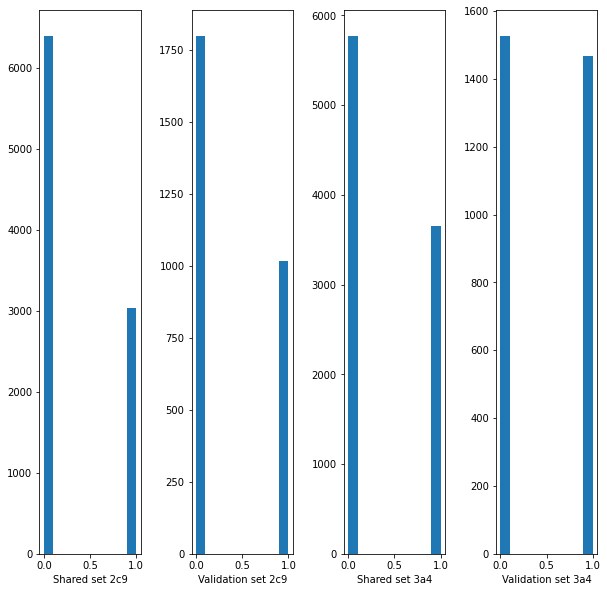

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(10,10))
ax[0].hist(labels_2c9)
ax[0].set_xlabel("Shared set 2c9")
ax[1].hist(labels_validation_2c9)
ax[1].set_xlabel("Validation set 2c9")
ax[2].hist(labels_3a4)
ax[2].set_xlabel("Shared set 3a4")
ax[3].hist(labels_validation_3a4)
ax[3].set_xlabel("Validation set 3a4")
plt.subplots_adjust(wspace=0.5)

We need to generate the features for the data sets, we will start by using the Morgan fingerprint as implemented in RDKit. The parameters are a match to those in the paper, 1024 bits and radius 2.

In [4]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [5]:
features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
np.save("shared_set_features.npy", features_shared)
features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
np.save("only_2c9_set_features.npy", features_only_2c9)
features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
np.save("only_3a4_set_features.npy", features_only_3a4)

We start fitting a model to the 2c9 isoform only, with 25% of the data to the test set, we will use the other 2c9 data set as validation.

(7065, 1024) (2355, 1024) (7065,) (2355,)


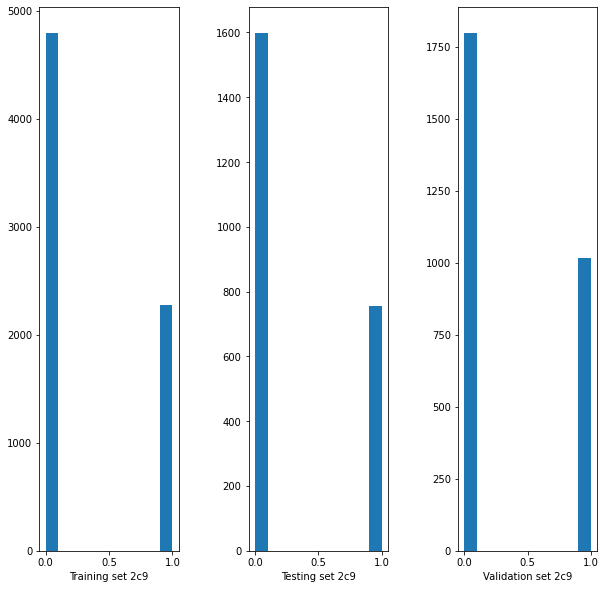

In [16]:
train_data, test_data, train_labels, test_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].hist(train_labels)
ax[0].set_xlabel("Training set 2c9")
ax[1].hist(test_labels)
ax[1].set_xlabel("Testing set 2c9")
ax[2].hist(labels_validation_2c9)
ax[2].set_xlabel("Validation set 2c9")
plt.subplots_adjust(wspace=0.5)

In [74]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, np.round(predicted_values)).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fp)
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}")

In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(1024,)),tf.keras.layers.Dropout(0.5)]+
    [tf.keras.layers.Dense(128, activation="relu") for _ in range(8)]+
    [tf.keras.layers.Dense(1, activation="sigmoid")])

model.summary()
loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.005), loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
history = model.fit(train_data, train_labels, epochs=10)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_305 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dropout_51 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_306 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_307 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_308 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_309 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_310 (Dense)            (None, 128)             

In [76]:
results = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)
# predictions = np.argmax(predictions, axis=1)
print_metrics(predictions, test_labels);

74/74 [==============================] - 0s 3ms/step - loss: 1.1077 - binary_accuracy: 0.7958
NER: 0.782, Sensitivity or recall: 0.744, Specificity: 0.820, Precision: 0.662, Correctly calssified: 0.766


In [78]:
results = model.evaluate(features_only_2c9, labels_validation_2c9)
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_validation_2c9);

88/88 [==============================] - 0s 3ms/step - loss: 1.5275 - binary_accuracy: 0.7266
NER: 0.727, Sensitivity or recall: 0.726, Specificity: 0.727, Precision: 0.600, Correctly calssified: 0.675


We've created a simple model that does not seem to perform very well, we will optimize the model by tunning the hyperparameters

In [79]:
%load_ext tensorboard
# Clear any logs from previous runs
#!rm -rf ./logs/

In [83]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(3, 10))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete([2**i for i in range(5,10)]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy')])
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1024, activation='relu', input_shape=(1024,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    model.fit(train_data, train_labels, epochs=5)
    _, results = model.evaluate(test_data, test_labels)
    return results

In [84]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar("accuracy", accuracy, step=1)

In [85]:
session_num = 0
looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
for neurons, hidden_lay, dropout, opt, l2, lr in looping:
    hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
    run_name = f"run_{session_num}"
    print(f"---Starting trial: {run_name}")
    print({h.name: hp_params[h] for h in hp_params})
    run('logs/hparam_tuning/' + run_name, hp_params)
    session_num += 1

---Starting trial: run_0
{'neurons': 32, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss: 0.5566 - binary_accuracy: 0.7659
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 0.4122 - binary_accuracy: 0.8422
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - loss: 0.3311 - binary_accuracy: 0.8832
Epoch 4/5
221/221 [==============================] - 2s 11ms/step - loss: 0.2501 - binary_accuracy: 0.9210
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 0.6258 - binary_accuracy: 0.7860
---Starting trial: run_1
{'neurons': 32, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss: 0.5675 - binary_accuracy: 0.7499
Epoch 2/5
221/221 [==============================] - 2s 11ms/s

74/74 [==============================] - 0s 2ms/step - loss: 0.7674 - binary_accuracy: 0.6786
---Starting trial: run_21
{'neurons': 32, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/5
221/221 [==============================] - 1s 4ms/step - loss: 0.7728 - binary_accuracy: 0.6753
Epoch 2/5
221/221 [==============================] - 1s 4ms/step - loss: 0.7425 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 4ms/step - loss: 0.7055 - binary_accuracy: 0.6838
Epoch 4/5
221/221 [==============================] - 1s 4ms/step - loss: 0.6425 - binary_accuracy: 0.7403
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.5792 - binary_accuracy: 0.7839
---Starting trial: run_22
{'neurons': 32, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/5
221/221 [==============================] - 1s 4ms/step - loss: 0.6808 - binar

221/221 [==============================] - 1s 6ms/step - loss: 0.3417 - binary_accuracy: 0.8651
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.6267 - binary_accuracy: 0.7975
---Starting trial: run_42
{'neurons': 32, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 1.7002 - binary_accuracy: 0.6684
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 0.7209 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 0.6596 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 0.6421 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.6390 - binary_accuracy: 0.6786
---Starting trial: run_43
{'neurons': 32, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'l

Epoch 1/5
221/221 [==============================] - 1s 4ms/step - loss: 0.6687 - binary_accuracy: 0.7272
Epoch 2/5
221/221 [==============================] - 1s 4ms/step - loss: 0.5461 - binary_accuracy: 0.8014
Epoch 3/5
221/221 [==============================] - 1s 4ms/step - loss: 0.4930 - binary_accuracy: 0.8205
Epoch 4/5
221/221 [==============================] - 1s 4ms/step - loss: 0.4489 - binary_accuracy: 0.8435
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.5039 - binary_accuracy: 0.8200
---Starting trial: run_53
{'neurons': 32, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/5
221/221 [==============================] - 1s 4ms/step - loss: 0.6917 - binary_accuracy: 0.6825
Epoch 2/5
221/221 [==============================] - 1s 4ms/step - loss: 0.6463 - binary_accuracy: 0.6892
Epoch 3/5
221/221 [==============================] - 1s 4ms/step - loss: 0.6498 - binary_accuracy: 0.6784
Epoch 4/5

Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 68799.0703 - binary_accuracy: 0.5703
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 508.7657 - binary_accuracy: 0.5595
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 468.4210 - binary_accuracy: 0.5704
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 440.2076 - binary_accuracy: 0.5633
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 409.8541 - binary_accuracy: 0.3214
---Starting trial: run_74
{'neurons': 32, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 77638877184.0000 - binary_accuracy: 0.6076
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 48783.1016 - binary_accuracy: 0.6283
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 48686.4922 - b

221/221 [==============================] - 2s 11ms/step - loss: 12132301144064.0000 - binary_accuracy: 0.5222
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 19725080576.0000 - binary_accuracy: 0.5836
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - loss: 6009108992.0000 - binary_accuracy: 0.5585
Epoch 4/5
221/221 [==============================] - 2s 11ms/step - loss: 11690435584.0000 - binary_accuracy: 0.5622
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 14110.8770 - binary_accuracy: 0.6786
---Starting trial: run_95
{'neurons': 32, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss: 0.6006 - binary_accuracy: 0.7568
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 0.4620 - binary_accuracy: 0.8226
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - 

Epoch 1/5
221/221 [==============================] - 1s 4ms/step - loss: 0.8362 - binary_accuracy: 0.6406
Epoch 2/5
221/221 [==============================] - 1s 4ms/step - loss: 0.8211 - binary_accuracy: 0.6778
Epoch 3/5
221/221 [==============================] - 1s 4ms/step - loss: 0.8090 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 1s 4ms/step - loss: 0.8009 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.7917 - binary_accuracy: 0.6786
---Starting trial: run_116
{'neurons': 32, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/5
221/221 [==============================] - 1s 4ms/step - loss: 0.8125 - binary_accuracy: 0.6784
Epoch 2/5
221/221 [==============================] - 1s 4ms/step - loss: 0.7889 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 4ms/step - loss: 0.7802 - binary_accuracy: 0.6784
Epoch 4/

Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 0.5342 - binary_accuracy: 0.7584
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 0.4113 - binary_accuracy: 0.8249
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 0.3571 - binary_accuracy: 0.8518
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 0.2887 - binary_accuracy: 0.8958
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.5837 - binary_accuracy: 0.8042
---Starting trial: run_137
{'neurons': 32, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 3.1197 - binary_accuracy: 0.6743
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 1.0358 - binary_accuracy: 0.6780
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 0.7914 - binary_accuracy: 0.6784
Epoch 4/

221/221 [==============================] - 2s 11ms/step - loss: 25.1929 - binary_accuracy: 0.6668
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 0.7209 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - loss: 0.7223 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 2s 11ms/step - loss: 0.7218 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.7206 - binary_accuracy: 0.6786
---Starting trial: run_158
{'neurons': 32, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss: 860112320.0000 - binary_accuracy: 0.6061
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 9600815.0000 - binary_accuracy: 0.6369
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - loss: 515970.1562 - binary_accur

221/221 [==============================] - 1s 6ms/step - loss: 0.6408 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.6317 - binary_accuracy: 0.6786
---Starting trial: run_168
{'neurons': 32, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 1.0}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 348023.2188 - binary_accuracy: 0.6386
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 580.8397 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 567.2292 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 555.2828 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 538.8719 - binary_accuracy: 0.6786
---Starting trial: run_169
{'neurons': 32, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regulariz

221/221 [==============================] - 2s 11ms/step - loss: 1196492.3750 - binary_accuracy: 0.6446
Epoch 4/5
221/221 [==============================] - 2s 11ms/step - loss: 322092.0312 - binary_accuracy: 0.6386
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 98.9949 - binary_accuracy: 0.6786
---Starting trial: run_189
{'neurons': 32, 'hidden_layers': 6, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss: 3764972729720111104.0000 - binary_accuracy: 0.5548
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 26508.5801 - binary_accuracy: 0.5615
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - loss: 136398707359744.0000 - binary_accuracy: 0.5581
Epoch 4/5
221/221 [==============================] - 2s 11ms/step - loss: 132662362636288.0000 - binary_accuracy: 0.5533
Epoch 5/5
74/74 [==============================] - 0

221/221 [==============================] - 1s 5ms/step - loss: nan - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 1s 5ms/step - loss: nan - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: nan - binary_accuracy: 0.6786
---Starting trial: run_210
{'neurons': 32, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss: 0.6294 - binary_accuracy: 0.7527
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 0.4829 - binary_accuracy: 0.8149
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - loss: 0.4218 - binary_accuracy: 0.8443
Epoch 4/5
221/221 [==============================] - 2s 11ms/step - loss: 0.3698 - binary_accuracy: 0.8712
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.5467 - binary_accuracy: 0.8068
---Starting trial: 

74/74 [==============================] - 0s 2ms/step - loss: 9928.5830 - binary_accuracy: 0.3214
---Starting trial: run_220
{'neurons': 32, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 0.6362 - binary_accuracy: 0.7355
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 0.4484 - binary_accuracy: 0.8245
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 0.3673 - binary_accuracy: 0.8644
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 0.2916 - binary_accuracy: 0.9018
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.5419 - binary_accuracy: 0.8072
---Starting trial: run_221
{'neurons': 32, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 0.561

74/74 [==============================] - 0s 3ms/step - loss: 0.5629 - binary_accuracy: 0.8072
---Starting trial: run_241
{'neurons': 32, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/5
221/221 [==============================] - 3s 11ms/step - loss: 0.6029 - binary_accuracy: 0.6989
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 0.4758 - binary_accuracy: 0.7875
Epoch 3/5
221/221 [==============================] - 3s 11ms/step - loss: 0.4250 - binary_accuracy: 0.8246
Epoch 4/5
221/221 [==============================] - 3s 11ms/step - loss: 0.3796 - binary_accuracy: 0.8534
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.5295 - binary_accuracy: 0.7945
---Starting trial: run_242
{'neurons': 32, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss:

Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 0.5652 - binary_accuracy: 0.7278
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 0.4403 - binary_accuracy: 0.8115
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 0.3917 - binary_accuracy: 0.8410
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 0.3440 - binary_accuracy: 0.8709
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 0.6894 - binary_accuracy: 0.8068
---Starting trial: run_252
{'neurons': 32, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 1.4661 - binary_accuracy: 0.6681
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 0.7663 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 0.6867 - binary_accuracy: 0.6784
Epoch 4

221/221 [==============================] - 2s 11ms/step - loss: 823.7321 - binary_accuracy: 0.6633
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 0.7322 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 2s 11ms/step - loss: 0.7278 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 2s 11ms/step - loss: 0.7272 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.7260 - binary_accuracy: 0.6786
---Starting trial: run_273
{'neurons': 32, 'hidden_layers': 7, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/5
221/221 [==============================] - 2s 11ms/step - loss: 89201319936.0000 - binary_accuracy: 0.5834
Epoch 2/5
221/221 [==============================] - 2s 11ms/step - loss: 445588.8438 - binary_accuracy: 0.6285
Epoch 3/5
221/221 [==============================] - 3s 11ms/step - loss: 760709760.0000 - binary

74/74 [==============================] - 0s 2ms/step - loss: 0.6661 - binary_accuracy: 0.7516
---Starting trial: run_293
{'neurons': 32, 'hidden_layers': 7, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/5
221/221 [==============================] - 1s 5ms/step - loss: 0.8035 - binary_accuracy: 0.6781
Epoch 2/5
221/221 [==============================] - 1s 5ms/step - loss: 0.7104 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 5ms/step - loss: 0.6633 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 1s 5ms/step - loss: 0.6443 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.6328 - binary_accuracy: 0.6786
---Starting trial: run_294
{'neurons': 32, 'hidden_layers': 7, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/5
221/221 [==============================] - 1s 5ms/step - loss: 0.8288 - bin

221/221 [==============================] - 1s 6ms/step - loss: 616.0121 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 607.9000 - binary_accuracy: 0.6725
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 595.8098 - binary_accuracy: 0.6786
---Starting trial: run_314
{'neurons': 32, 'hidden_layers': 8, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 59564650865360896.0000 - binary_accuracy: 0.6003
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 63075.4297 - binary_accuracy: 0.6221
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 63075.4258 - binary_accuracy: 0.6249
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 63075.5547 - binary_accuracy: 0.5960
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 63075.4922 - bina

221/221 [==============================] - 3s 11ms/step - loss: 428658661221466112.0000 - binary_accuracy: 0.5674
Epoch 3/5
221/221 [==============================] - 3s 12ms/step - loss: 36567.2969 - binary_accuracy: 0.5529
Epoch 4/5
221/221 [==============================] - 3s 12ms/step - loss: 51765007435694080000.0000 - binary_accuracy: 0.5464
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 20338.5898 - binary_accuracy: 0.3214
---Starting trial: run_335
{'neurons': 32, 'hidden_layers': 8, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/5
221/221 [==============================] - 3s 11ms/step - loss: 0.6559 - binary_accuracy: 0.7338
Epoch 2/5
221/221 [==============================] - 3s 11ms/step - loss: 0.5013 - binary_accuracy: 0.8035
Epoch 3/5
221/221 [==============================] - 3s 11ms/step - loss: 0.4407 - binary_accuracy: 0.8381
Epoch 4/5
221/221 [==============================] - 3s 11ms/step - l

Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 65639.3984 - binary_accuracy: 0.6294
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 65638.1719 - binary_accuracy: 0.6786
---Starting trial: run_345
{'neurons': 32, 'hidden_layers': 8, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.001}
Epoch 1/5
221/221 [==============================] - 1s 6ms/step - loss: 0.6565 - binary_accuracy: 0.7401
Epoch 2/5
221/221 [==============================] - 1s 6ms/step - loss: 0.4538 - binary_accuracy: 0.8273
Epoch 3/5
221/221 [==============================] - 1s 6ms/step - loss: 0.3813 - binary_accuracy: 0.8610
Epoch 4/5
221/221 [==============================] - 1s 6ms/step - loss: 0.3225 - binary_accuracy: 0.8878
Epoch 5/5
74/74 [==============================] - 0s 3ms/step - loss: 0.5602 - binary_accuracy: 0.8166
---Starting trial: run_346
{'neurons': 32, 'hidden_layers': 8, 'dropout': 0.5, 'optimizer': 'adam', 'l2 re

Epoch 1/5
221/221 [==============================] - 1s 5ms/step - loss: 0.9741 - binary_accuracy: 0.6204
Epoch 2/5
221/221 [==============================] - 1s 5ms/step - loss: 0.9626 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 5ms/step - loss: 0.9533 - binary_accuracy: 0.6784
Epoch 4/5
221/221 [==============================] - 1s 5ms/step - loss: 0.9456 - binary_accuracy: 0.6784
Epoch 5/5
74/74 [==============================] - 0s 2ms/step - loss: 0.9366 - binary_accuracy: 0.6786
---Starting trial: run_356
{'neurons': 32, 'hidden_layers': 8, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/5
221/221 [==============================] - 1s 5ms/step - loss: 0.9397 - binary_accuracy: 0.6621
Epoch 2/5
221/221 [==============================] - 1s 5ms/step - loss: 0.9106 - binary_accuracy: 0.6784
Epoch 3/5
221/221 [==============================] - 1s 5ms/step - loss: 0.9050 - binary_accuracy: 0.6784
Epoch 4/

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_774/dense_5757/MatMul (defined at <ipython-input-83-efaf7bf87fdc>:27) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_3088369]

Function call stack:
train_function


In [86]:
%tensorboard --logdir logs/hparam_tuning